![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

# Clinical Named Entity Recognition (NER)

##  1. NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that automatically detects word and character-level features using a hybrid bidirectional LSTM and CNN architecture, eliminating the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length feature vector from character-level features. For each word, these vectors are concatenated and fed to the BLSTM network and then to the output layers. They employed a stacked bi-directional recurrent neural network with long short-term memory units to transform word features into named entity tag scores. The extracted features of each word are fed into a forward LSTM network and a backward LSTM network. The output of each network at each time step is decoded by a linear layer and a log-softmax layer into log-probabilities for each tag category. These two vectors are then simply added together to produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word embeddings is used for word features, 25-dimension character embeddings is used for char features, and capitalization features (allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used for case features.

## 2. Blogposts and videos:

- [How to Setup Spark NLP for HEALTHCARE on UBUNTU - Video](https://www.youtube.com/watch?v=yKnF-_oz0GE)

- [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77)

- [State of the art Clinical Named Entity Recognition in Spark NLP - Youtube](https://www.youtube.com/watch?v=YM-e4eOiQ34)

- [Named Entity Recognition for Healthcare with SparkNLP NerDL and NerCRF](https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571)

- [Named Entity Recognition for Clinical Text](https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180)

## 3. Colab Setup

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [2]:
license_keys.keys()

dict_keys(['AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'PUBLIC_VERSION', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION'])

In [3]:
license_keys['JSL_VERSION']

'4.2.4'

In [4]:
license_keys['PUBLIC_VERSION']

'4.2.4'

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing nlu
! pip install --upgrade -q nlu==4.0.1rc4 --no-dependencies 

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [6]:
import json
import os

import sparknlp
import sparknlp_jsl
import nlu

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 4.2.4
Spark NLP_JSL Version : 4.2.4


In [7]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

## 4. Clinical NER Pipeline (with pretrained models)

## Clinical NER Models
|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [jsl_ner_wip_clinical](https://nlp.johnsnowlabs.com/2021/03/31/jsl_ner_wip_clinical_en.html)  | 2| [jsl_ner_wip_greedy_clinical](https://nlp.johnsnowlabs.com/2021/03/31/jsl_ner_wip_greedy_clinical_en.html)  | 3| [jsl_ner_wip_modifier_clinical](https://nlp.johnsnowlabs.com/2021/04/01/jsl_ner_wip_modifier_clinical_en.html)  | 4| [jsl_rd_ner_wip_greedy_clinical](https://nlp.johnsnowlabs.com/2021/04/01/jsl_rd_ner_wip_greedy_clinical_en.html)  |
| 5| [ner_abbreviation_clinical](https://nlp.johnsnowlabs.com/2021/12/30/ner_abbreviation_clinical_en.html)  | 6| [ner_ade_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinical_en.html)  | 7| [ner_ade_clinicalbert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinicalbert_en.html)  | 8| [ner_ade_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_healthcare_en.html)  |
| 9| [ner_anatomy](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_en.html)  | 10| [ner_anatomy_coarse](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_coarse_en.html)  | 11| [ner_anatomy_coarse_en](https://nlp.johnsnowlabs.com/2020/11/04/ner_anatomy_coarse_en.html)  | 12| [ner_anatomy_en](https://nlp.johnsnowlabs.com/2020/04/22/ner_anatomy_en.html)  |
| 13| [ner_aspect_based_sentiment](https://nlp.johnsnowlabs.com/2021/03/31/ner_aspect_based_sentiment_en.html)  | 14| [ner_bacterial_species](https://nlp.johnsnowlabs.com/2021/04/01/ner_bacterial_species_en.html)  | 15| [ner_biomarker](https://nlp.johnsnowlabs.com/2021/11/26/ner_biomarker_en.html)  | 16| [ner_biomedical_bc2gm](https://nlp.johnsnowlabs.com/2022/05/11/ner_biomedical_bc2gm_en_2_4.html)  |
| 17| [ner_bionlp](https://nlp.johnsnowlabs.com/2021/03/31/ner_bionlp_en.html)  | 18| [ner_bionlp_en](https://nlp.johnsnowlabs.com/2020/01/30/ner_bionlp_en.html)  | 19| [ner_cancer_genetics](https://nlp.johnsnowlabs.com/2021/03/31/ner_cancer_genetics_en.html)  | 20| [ner_cellular](https://nlp.johnsnowlabs.com/2021/03/31/ner_cellular_en.html)  |
| 21| [ner_cellular_en](https://nlp.johnsnowlabs.com/2020/04/22/ner_cellular_en.html)  | 22| [ner_chemd_clinical](https://nlp.johnsnowlabs.com/2021/11/04/ner_chemd_clinical_en.html)  | 23| [ner_chemicals](https://nlp.johnsnowlabs.com/2021/04/01/ner_chemicals_en.html)  | 24| [ner_chemprot_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_chemprot_clinical_en.html)  |
| 25| [ner_chexpert](https://nlp.johnsnowlabs.com/2021/09/30/ner_chexpert_en.html)  | 26| [ner_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_clinical_en.html)  | 27| [ner_clinical_en](https://nlp.johnsnowlabs.com/2020/01/30/ner_clinical_en.html)  | 28| [ner_clinical_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_clinical_large_en.html)  |
| 29| [ner_clinical_large_en](https://nlp.johnsnowlabs.com/2020/05/23/ner_clinical_large_en.html)  | 30| [ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/06/22/ner_clinical_trials_abstracts_en_3_0.html)  | 31| [ner_covid_trials](https://nlp.johnsnowlabs.com/2022/10/19/ner_covid_trials_en.html)  | 32| [ner_crf](https://nlp.johnsnowlabs.com/2020/01/28/ner_crf_en.html)  |
| 33| [ner_deid_augmented](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_augmented_en.html)  | 34| [ner_deid_enriched](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_enriched_en.html)  | 35| [ner_deid_generic_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_generic_glove_en.html)  | 36| [ner_deid_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_large_en.html)  |
| 37| [ner_deid_sd](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_en.html)  | 38| [ner_deid_sd_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_large_en.html)  | 39| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html)  | 40| [ner_deid_subentity_augmented_i2b2](https://nlp.johnsnowlabs.com/2021/11/29/ner_deid_subentity_augmented_i2b2_en.html)  |
| 41| [ner_deid_subentity_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_subentity_glove_en.html)  | 42| [ner_deid_synthetic](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_synthetic_en.html)  | 43| [ner_deidentify_dl](https://nlp.johnsnowlabs.com/2021/03/31/ner_deidentify_dl_en.html)  | 44| [ner_diseases](https://nlp.johnsnowlabs.com/2021/03/31/ner_diseases_en.html)  |
| 45| [ner_diseases_en](https://nlp.johnsnowlabs.com/2020/03/25/ner_diseases_en.html)  | 46| [ner_diseases_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_diseases_large_en.html)  | 47| [ner_drugprot_clinical](https://nlp.johnsnowlabs.com/2021/12/20/ner_drugprot_clinical_en.html)  | 48| [ner_drugs](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_en.html)  |
| 49| [ner_drugs_en](https://nlp.johnsnowlabs.com/2020/03/25/ner_drugs_en.html)  | 50| [ner_drugs_greedy](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_greedy_en.html)  | 51| [ner_drugs_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_large_en.html)  | 52| [ner_drugs_large_en](https://nlp.johnsnowlabs.com/2021/01/29/ner_drugs_large_en.html)  |
| 53| [ner_events_admission_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_events_admission_clinical_en.html)  | 54| [ner_events_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_events_clinical_en.html)  | 55| [ner_events_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_events_healthcare_en.html)  | 56| [ner_financial_contract](https://nlp.johnsnowlabs.com/2021/04/01/ner_financial_contract_en.html)  |
| 57| [ner_genetic_variants](https://nlp.johnsnowlabs.com/2021/06/25/ner_genetic_variants_en.html)  | 58| [ner_healthcare](https://nlp.johnsnowlabs.com/2021/04/21/ner_healthcare_en.html)  | 59| [ner_healthcare_en](https://nlp.johnsnowlabs.com/2020/03/26/ner_healthcare_en.html)  | 60| [ner_human_phenotype_gene_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_human_phenotype_gene_clinical_en.html)  |
| 61| [ner_human_phenotype_go_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_human_phenotype_go_clinical_en.html)  | 62| [ner_jsl](https://nlp.johnsnowlabs.com/2022/10/19/ner_jsl_en.html)  | 63| [ner_jsl_en](https://nlp.johnsnowlabs.com/2020/04/22/ner_jsl_en.html)  | 64| [ner_jsl_enriched](https://nlp.johnsnowlabs.com/2021/10/22/ner_jsl_enriched_en.html)  |
| 65| [ner_jsl_enriched_en](https://nlp.johnsnowlabs.com/2020/04/22/ner_jsl_enriched_en.html)  | 66| [ner_jsl_greedy](https://nlp.johnsnowlabs.com/2021/06/24/ner_jsl_greedy_en.html)  | 67| [ner_jsl_slim](https://nlp.johnsnowlabs.com/2021/08/13/ner_jsl_slim_en.html)  | 68| [ner_living_species](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_en_3_0.html)  |
| 69| [ner_measurements_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_measurements_clinical_en.html)  | 70| [ner_medmentions_coarse](https://nlp.johnsnowlabs.com/2021/04/01/ner_medmentions_coarse_en.html)  | 71| [ner_nature_nero_clinical](https://nlp.johnsnowlabs.com/2022/02/08/ner_nature_nero_clinical_en.html)  | 72| [ner_nihss](https://nlp.johnsnowlabs.com/2021/11/15/ner_nihss_en.html)  |
| 73| [ner_oncology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_en.html)  | 74| [ner_oncology_anatomy_general](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_anatomy_general_en.html)  | 75| [ner_oncology_anatomy_granular](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_anatomy_granular_en.html)  | 76| [ner_oncology_biomarker](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_biomarker_en.html)  |
| 77| [ner_oncology_demographics](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_demographics_en.html)  | 78| [ner_oncology_diagnosis](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_diagnosis_en.html)  | 79| [ner_oncology_posology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_posology_en.html)  | 80| [ner_oncology_response_to_treatment](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_response_to_treatment_en.html)  |
| 81| [ner_oncology_test](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_test_en.html)  | 82| [ner_oncology_therapy](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_therapy_en.html)  | 83| [ner_oncology_tnm](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_tnm_en.html)  | 84| [ner_oncology_unspecific_posology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_unspecific_posology_en.html)  |
| 85| [ner_pathogen](https://nlp.johnsnowlabs.com/2022/06/28/ner_pathogen_en_3_0.html)  | 86| [ner_posology](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_en.html)  | 87| [ner_posology_en](https://nlp.johnsnowlabs.com/2020/04/15/ner_posology_en.html)  | 88| [ner_posology_experimental](https://nlp.johnsnowlabs.com/2021/09/01/ner_posology_experimental_en.html)  |
| 89| [ner_posology_greedy](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_greedy_en.html)  | 90| [ner_posology_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_healthcare_en.html)  | 91| [ner_posology_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_large_en.html)  | 92| [ner_posology_small](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_small_en.html)  |
| 93| [ner_radiology](https://nlp.johnsnowlabs.com/2021/03/31/ner_radiology_en.html)  | 94| [ner_radiology_wip_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_radiology_wip_clinical_en.html)  | 95| [ner_risk_factors](https://nlp.johnsnowlabs.com/2021/03/31/ner_risk_factors_en.html)  | 96| [ner_risk_factors_en](https://nlp.johnsnowlabs.com/2020/04/22/ner_risk_factors_en.html)  |
| 97| [ner_sdoh_mentions](https://nlp.johnsnowlabs.com/2022/12/18/ner_sdoh_mentions_en.html)  | 98| [ner_sdoh_mentions_test](https://nlp.johnsnowlabs.com/2022/12/18/ner_sdoh_mentions_test_en.html)  | 99| [ner_supplement_clinical](https://nlp.johnsnowlabs.com/2022/02/01/ner_supplement_clinical_en.html)  | 100| [nerdl_tumour_demo](https://nlp.johnsnowlabs.com/2021/04/01/nerdl_tumour_demo_en.html)  |




- **BioBert NER Models**

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [jsl_ner_wip_greedy_biobert](https://nlp.johnsnowlabs.com/2021/07/26/jsl_ner_wip_greedy_biobert_en.html)  | 2| [jsl_rd_ner_wip_greedy_biobert](https://nlp.johnsnowlabs.com/2021/07/26/jsl_rd_ner_wip_greedy_biobert_en.html)  | 3| [ner_ade_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_biobert_en.html)  | 4| [ner_anatomy_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_anatomy_biobert_en.html)  |
| 5| [ner_anatomy_coarse_biobert](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_coarse_biobert_en.html)  | 6| [ner_bionlp_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_bionlp_biobert_en.html)  | 7| [ner_cellular_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_cellular_biobert_en.html)  | 8| [ner_chemprot_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_chemprot_biobert_en.html)  |
| 9| [ner_clinical_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_clinical_biobert_en.html)  | 10| [ner_deid_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_biobert_en.html)  | 11| [ner_deid_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_enriched_biobert_en.html)  | 12| [ner_diseases_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_diseases_biobert_en.html)  |
| 13| [ner_events_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_events_biobert_en.html)  | 14| [ner_human_phenotype_gene_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_human_phenotype_gene_biobert_en.html)  | 15| [ner_human_phenotype_go_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_human_phenotype_go_biobert_en.html)  | 16| [ner_jsl_biobert](https://nlp.johnsnowlabs.com/2021/09/05/ner_jsl_biobert_en.html)  |
| 17| [ner_jsl_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_jsl_enriched_biobert_en.html)  | 18| [ner_jsl_greedy_biobert](https://nlp.johnsnowlabs.com/2021/08/13/ner_jsl_greedy_biobert_en.html)  | 19| [ner_living_species_biobert](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_biobert_en_3_0.html)  | 20| [ner_posology_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_biobert_en.html)  |
| 21| [ner_posology_large_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_large_biobert_en.html)  | 22| [ner_risk_factors_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_risk_factors_biobert_en.html)  | 23| []()| 24| []()|




- **BertForTokenClassification Clinical NER models**

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [bert_token_classifier_ade_tweet_binary](https://nlp.johnsnowlabs.com/2022/07/29/bert_token_classifier_ade_tweet_binary_en_3_0.html)  | 2| [bert_token_classifier_drug_development_trials](https://nlp.johnsnowlabs.com/2022/03/22/bert_token_classifier_drug_development_trials_en_3_0.html)  | 3| [bert_token_classifier_ner_ade](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_ade_en.html)  | 4| [bert_token_classifier_ner_ade_binary](https://nlp.johnsnowlabs.com/2022/07/27/bert_token_classifier_ner_ade_binary_en_3_0.html)  |
| 5| [bert_token_classifier_ner_anatem](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_anatem_en_3_0.html)  | 6| [bert_token_classifier_ner_anatomy](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_anatomy_en.html)  | 7| [bert_token_classifier_ner_bacteria](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_bacteria_en.html)  | 8| [bert_token_classifier_ner_bc2gm_gene](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc2gm_gene_en_3_0.html)  |
| 9| [bert_token_classifier_ner_bc4chemd_chemicals](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc4chemd_chemicals_en_3_0.html)  | 10| [bert_token_classifier_ner_bc5cdr_chemicals](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc5cdr_chemicals_en_3_0.html)  | 11| [bert_token_classifier_ner_bc5cdr_disease](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc5cdr_disease_en_3_0.html)  | 12| [bert_token_classifier_ner_bionlp](https://nlp.johnsnowlabs.com/2021/11/03/bert_token_classifier_ner_bionlp_en.html)  |
| 13| [bert_token_classifier_ner_cellular](https://nlp.johnsnowlabs.com/2021/11/03/bert_token_classifier_ner_cellular_en.html)  | 14| [bert_token_classifier_ner_chemicals](https://nlp.johnsnowlabs.com/2021/10/19/bert_token_classifier_ner_chemicals_en.html)  | 15| [bert_token_classifier_ner_chemprot](https://nlp.johnsnowlabs.com/2021/10/19/bert_token_classifier_ner_chemprot_en.html)  | 16| [bert_token_classifier_ner_clinical](https://nlp.johnsnowlabs.com/2022/01/06/bert_token_classifier_ner_clinical_en.html)  |
| 17| [bert_token_classifier_ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/06/29/bert_token_classifier_ner_clinical_trials_abstracts_en_3_0.html)  | 18| [bert_token_classifier_ner_deid](https://nlp.johnsnowlabs.com/2021/09/13/bert_token_classifier_ner_deid_en.html)  | 19| [bert_token_classifier_ner_drugs](https://nlp.johnsnowlabs.com/2021/09/20/bert_token_classifier_ner_drugs_en.html)  | 20| [bert_token_classifier_ner_jnlpba_cellular](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_jnlpba_cellular_en_3_0.html)  |
| 21| [bert_token_classifier_ner_jsl](https://nlp.johnsnowlabs.com/2021/09/16/bert_token_classifier_ner_jsl_en.html)  | 22| [bert_token_classifier_ner_jsl_slim](https://nlp.johnsnowlabs.com/2021/09/24/bert_token_classifier_ner_jsl_slim_en.html)  | 23| [bert_token_classifier_ner_linnaeus_species](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_linnaeus_species_en_3_0.html)  | 24| [bert_token_classifier_ner_living_species](https://nlp.johnsnowlabs.com/2022/06/26/bert_token_classifier_ner_living_species_en_3_0.html)  |
| 25| [bert_token_classifier_ner_ncbi_disease](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_ncbi_disease_en_3_0.html)  | 26| [bert_token_classifier_ner_pathogen](https://nlp.johnsnowlabs.com/2022/07/28/bert_token_classifier_ner_pathogen_en_3_0.html)  | 27| [bert_token_classifier_ner_species](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_species_en_3_0.html)  | 28| [bert_token_classifier_ner_supplement](https://nlp.johnsnowlabs.com/2022/02/09/bert_token_classifier_ner_supplement_en.html)  |






**You can find all these models and more [NLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Named+Entity+Recognition&edition=Spark+NLP+for+Healthcare)**

**Also, you can print the list of clinical pretrained models/pipelines and annotators with one-line code:**

In [8]:
from sparknlp_jsl.pretrained import InternalResourceDownloader

# pipelines = InternalResourceDownloader.returnPrivatePipelines()
ner_models = InternalResourceDownloader.returnPrivateModels("MedicalNerModel")
ner_models

[['nerdl_tumour_demo', 'en', '1.7.3'],
 ['nerdl_tumour_demo', 'en', '1.8.0'],
 ['nerdl_tumour_demo', 'en', '2.0.2'],
 ['ner_healthcare', 'en', '2.4.4'],
 ['ner_radiology', 'en', '2.7.0'],
 ['ner_deid_augmented', 'en', '2.7.1'],
 ['ner_deidentify_dl', 'en', '2.7.2'],
 ['ner_events_admission_clinical', 'en', '2.7.4'],
 ['ner_clinical', 'en', '3.0.0'],
 ['ner_radiology', 'en', '3.0.0'],
 ['ner_bionlp', 'en', '3.0.0'],
 ['ner_posology', 'en', '3.0.0'],
 ['ner_healthcare', 'de', '3.0.0'],
 ['ner_deid_augmented', 'en', '3.0.0'],
 ['ner_anatomy', 'en', '3.0.0'],
 ['ner_risk_factors', 'en', '3.0.0'],
 ['ner_chemprot_clinical', 'en', '3.0.0'],
 ['ner_posology_small', 'en', '3.0.0'],
 ['ner_diag_proc', 'es', '3.0.0'],
 ['ner_posology_greedy', 'en', '3.0.0'],
 ['ner_deid_enriched', 'en', '3.0.0'],
 ['ner_drugs_greedy', 'en', '3.0.0'],
 ['jsl_ner_wip_clinical', 'en', '3.0.0'],
 ['ner_posology_large', 'en', '3.0.0'],
 ['jsl_ner_wip_greedy_clinical', 'en', '3.0.0'],
 ['ner_clinical_large', 'en', '3.

In [9]:
from sparknlp_jsl.compatibility import Compatibility 

compatibility = Compatibility(spark)

models = compatibility.findVersion('ner') 

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

,name,sparkVersion,version,language,date,readyToUse
0,nerdl_tumour_demo,2,1.7.3,en,2018-12-19T16:52:37.735,true
1,nercrf_tumour_demo,2,1.7.3,en,2018-12-19T17:23:53.776,true
2,nerdl_tumour_demo,2.4,1.8.0,en,2018-12-22T04:21:25.574,true
3,nercrf_tumour_demo,2.4,1.8.0,en,2018-12-22T04:46:26.992,true
4,nercrf_tumour_demo,2.4,2.0.2,en,2019-05-21T18:23:13.066,true
...,...,...,...,...,...,...
563,genericclassifier_sdoh_alcohol_usage_binary_sbiobert_cased_mli,3.0,4.2.4,en,2023-01-14T12:23:22.618,true
564,genericclassifier_sdoh_alcohol_usage_sbiobert_cased_mli,3.0,4.2.4,en,2023-01-14T12:15:50.774,true
565,genericclassifier_sdoh_substance_usage_binary_sbiobert_cased_mli,3.0,4.2.4,en,2023-01-14T12:06:13.649,true
566,genericclassifier_sdoh_tobacco_usage_sbiobert_cased_mli,3.0,4.2.4,en,2023-01-14T11:57:48.673,true


In [10]:
# find oncology NER models

models = compatibility.findVersion("ner_oncology")

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

,name,sparkVersion,version,language,date,readyToUse
0,ner_oncology_wip,3.0,3.5.0,en,2022-07-25T17:48:26.053,true
1,ner_oncology_unspecific_posology_wip,3.0,4.0.0,en,2022-09-30T18:49:12.336,true
2,ner_oncology_wip,3.0,4.0.0,en,2022-09-30T16:54:45.893,true
3,ner_oncology_therapy_wip,3.0,4.0.0,en,2022-09-30T17:12:16.894,true
4,ner_oncology_posology_wip,3.0,4.0.0,en,2022-10-01T04:46:44.423,true
5,ner_oncology_anatomy_general_wip,3.0,4.0.0,en,2022-09-30T18:23:57.279,true
6,ner_oncology_tnm_wip,3.0,4.0.0,en,2022-09-30T18:15:05.395,true
7,ner_oncology_demographics_wip,3.0,4.0.0,en,2022-09-30T18:45:57.899,true
8,ner_oncology_biomarker_wip,3.0,4.0.0,en,2022-10-01T00:36:21.032,true
9,ner_oncology_anatomy_granular_wip,3.0,4.0.0,en,2022-10-01T00:31:24.877,true


## Clinical NER Pipeline (with pretrained models)

In [11]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")
 
# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
    .setInputCols(["sentence","token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper") #decide if we want to return the tags in upper or lower case 

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter
        ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
[OK!]


In [12]:
model.stages

[DocumentAssembler_8b01550ce6b5,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_ba6fa29580ce,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NER_CONVERTER_956f35881292]

In [13]:
clinical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [14]:
clinical_ner.extractParamMap()

{Param(parent='MedicalNerModel_1a8637089929', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_1a8637089929', name='labelCasing', doc='Setting all labels of the NER models upper/lower case. values upper|lower'): 'upper',
 Param(parent='MedicalNerModel_1a8637089929', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_1a8637089929', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_1a8637089929', name='classes', doc='get the tags used to trained this Medic

In [15]:
clinical_ner.getStorageRef()

'clinical'

In [16]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples_10.csv

In [17]:
mt_samples_df = spark.read.csv("mt_samples_10.csv", header=True, multiLine=True)

In [18]:
mt_samples_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- text: string (nullable = true)



In [19]:
mt_samples_df.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Sample Type / Med...|
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
+-----+--------------------+



In [20]:
print(mt_samples_df.limit(1).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

In [21]:
result = model.transform(mt_samples_df).cache()

In [22]:
result.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 118, 129...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 92, ...|
|    2|Sample Type / Med...|[{document, 0, 42...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 73, ...|
|    3|Sample Type / Med...|[{document, 0, 20...|[{document, 0, 53...|

In [23]:
%%time

result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PROBLEM, O, B-PROBLEM, I-PROBLEM, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, I-TREATMENT, I-TREA

In [24]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result, 
                                                 result.ner.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"),
                          F.expr("cols['2']['confidence']").alias("confidence"))

result_df.show(50, truncate=100)

+-------------+---------+----------+
|        token|ner_label|confidence|
+-------------+---------+----------+
|       Sample|        O|    0.9996|
|         Type|        O|    0.9926|
|            /|        O|    0.9755|
|      Medical|        O|    0.9824|
|    Specialty|        O|    0.9993|
|            :|        O|       1.0|
|   Hematology|        O|    0.9971|
|            -|        O|    0.9908|
|     Oncology|        O|    0.9796|
|       Sample|        O|    0.9999|
|         Name|        O|    0.9994|
|            :|        O|       1.0|
|    Discharge|        O|    0.9998|
|      Summary|        O|    0.9926|
|            -|        O|    0.9959|
| Mesothelioma|        O|    0.8117|
|            -|        O|    0.9934|
|            1|        O|    0.7394|
|  Description|        O|    0.9995|
|            :|        O|    0.9999|
| Mesothelioma|B-PROBLEM|    0.9991|
|            ,|        O|    0.9999|
|      pleural|B-PROBLEM|    0.9911|
|     effusion|I-PROBLEM|    0.9982|
|

In [25]:
result_df.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |4721 |
|I-PROBLEM  |526  |
|B-PROBLEM  |399  |
|I-TREATMENT|326  |
|B-TREATMENT|265  |
|I-TEST     |173  |
|B-TEST     |142  |
+-----------+-----+



In [26]:
result.select('ner_chunk').take(1)

[Row(ner_chunk=[Row(annotatorType='chunk', begin=118, end=129, result='Mesothelioma', metadata={'sentence': '2', 'chunk': '0', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9991'}, embeddings=[]), Row(annotatorType='chunk', begin=132, end=147, result='pleural effusion', metadata={'sentence': '2', 'chunk': '1', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.99465'}, embeddings=[]), Row(annotatorType='chunk', begin=150, end=168, result='atrial fibrillation', metadata={'sentence': '2', 'chunk': '2', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9979'}, embeddings=[]), Row(annotatorType='chunk', begin=171, end=176, result='anemia', metadata={'sentence': '2', 'chunk': '3', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.999'}, embeddings=[]), Row(annotatorType='chunk', begin=179, end=185, result='ascites', metadata={'sentence': '2', 'chunk': '4', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9996'}, 

In [27]:
row_list = [{'annotatorType': row.annotatorType, 
             'begin': row.begin, 
             'end': row.end,
             'result': row.result,
             'metadata': row.metadata} 
            for row in result.select('ner_chunk').take(1)[0][0]
           ]

row_list

[{'annotatorType': 'chunk',
  'begin': 118,
  'end': 129,
  'result': 'Mesothelioma',
  'metadata': {'sentence': '2',
   'chunk': '0',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.9991'}},
 {'annotatorType': 'chunk',
  'begin': 132,
  'end': 147,
  'result': 'pleural effusion',
  'metadata': {'sentence': '2',
   'chunk': '1',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.99465'}},
 {'annotatorType': 'chunk',
  'begin': 150,
  'end': 168,
  'result': 'atrial fibrillation',
  'metadata': {'sentence': '2',
   'chunk': '2',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.9979'}},
 {'annotatorType': 'chunk',
  'begin': 171,
  'end': 176,
  'result': 'anemia',
  'metadata': {'sentence': '2',
   'chunk': '3',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.999'}},
 {'annotatorType': 'chunk',
  'begin': 179,
  'end': 185,
  'result': 'ascites',
  'metadata': {'sentence': '2',
   'chunk'

In [28]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['1']['confidence']").alias("confidence")).show(truncate=False)

+-------------------------+---------+----------+
|chunk                    |ner_label|confidence|
+-------------------------+---------+----------+
|Mesothelioma             |PROBLEM  |0.9991    |
|pleural effusion         |PROBLEM  |0.99465   |
|atrial fibrillation      |PROBLEM  |0.9979    |
|anemia                   |PROBLEM  |0.999     |
|ascites                  |PROBLEM  |0.9996    |
|esophageal reflux        |PROBLEM  |0.9979    |
|deep venous thrombosis   |PROBLEM  |0.96760005|
|Mesothelioma             |PROBLEM  |0.987     |
|Pleural effusion         |PROBLEM  |0.97895   |
|atrial fibrillation      |PROBLEM  |0.99475   |
|anemia                   |PROBLEM  |0.9984    |
|ascites                  |PROBLEM  |0.9994    |
|esophageal reflux        |PROBLEM  |0.99724996|
|deep venous thrombosis   |PROBLEM  |0.9550001 |
|decortication of the lung|TREATMENT|0.756325  |
|pleural biopsy           |TEST     |0.87715   |
|transpleural fluoroscopy |TEST     |0.9527    |
|thoracentesis      

### LightPipelines

In [29]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting. 
She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27. 
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []
confidence = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    confidence.append(n.metadata["confidence"])
    

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities, 'confidence':confidence})

df_clinical.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting. 
She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27. 



,chunks,begin,end,sentence_id,entities,confidence
0,gestational diabetes mellitus,40,68,0,PROBLEM,0.91976666
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM,0.75924003
2,T2DM,157,160,0,PROBLEM,0.9917
3,HTG-induced pancreatitis,185,208,0,PROBLEM,0.97535
4,an acute hepatitis,265,282,0,PROBLEM,0.9440667
5,polyuria,322,329,0,PROBLEM,0.9728
6,poor appetite,332,344,0,PROBLEM,0.9934
7,vomiting,351,358,0,PROBLEM,0.9854
8,metformin,373,381,1,TREATMENT,0.9998
9,glipizide,384,392,1,TREATMENT,0.9999


In [30]:
light_result[0]

{'document': [Annotation(document, 0, 881, 
  A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting. 
  She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. 
  Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27. 
  , {})],
 'ner_chunk': [Annotation(chunk, 40, 68, gestational diabet

**Getting embeddings with LP**

In [31]:
light_model_with_emb = LightPipeline(model, parse_embeddings=True)
light_result_with_emb = light_model_with_emb.annotate(text)

list(zip(light_result_with_emb['token'], light_result_with_emb['embeddings']))[:3]

[('A',
  '0.040217556 0.4003962 0.69088835 -0.44649735 -0.40282863 -0.45621523 -0.20415598 0.13707675 -0.010474405 -0.42899358 -0.2879874 -0.03076839 -0.40367207 -0.32588458 0.23294163 -0.16012932 -0.35798857 0.043061644 -0.4091242 0.101141304 -0.61503464 0.068771854 -0.025053142 0.11466996 -0.57737786 -0.25603554 -0.6950373 0.3328502 -0.100428 0.0191588 -0.61035156 -0.94459176 -0.2473863 0.16416614 -0.27778018 0.40670344 0.57310873 0.10776807 0.13333033 0.1447822 0.18491237 0.2196365 0.16771133 -0.40313882 -0.20199609 0.045175955 -0.2593916 -0.066459864 0.15229034 0.002910823 -0.16859493 0.17066914 -9.03164E-4 0.03531517 -0.33315992 -0.034506235 0.40311962 0.023356766 0.13823766 -0.2634582 0.27318013 -0.15994109 0.40696687 0.19050935 -0.19682823 -0.012536205 0.4694685 -0.14188287 -0.024362855 -0.38291803 0.013956237 0.1830807 0.34642568 -0.23263279 -0.14591216 -0.2337688 0.5834314 -0.03057853 -0.367189 0.56245005 -0.032807935 0.122141086 0.17941982 -0.00749746 -0.18216385 0.17958473 -

**Prettifying the results with NLU**



John Snow Labs' NLU is a Python library for applying state-of-the-art text mining, directly on any dataframe, with a single line of code. We will use some functionalities of NLU to prettify our results. 

In [32]:
nlu.to_pretty_df(model, text, positions=True, output_level='chunk').columns

Index(['document', 'document_begin', 'document_end', 'entities_ner_chunk',
       'entities_ner_chunk_begin', 'entities_ner_chunk_class',
       'entities_ner_chunk_confidence', 'entities_ner_chunk_end',
       'entities_ner_chunk_origin_chunk', 'entities_ner_chunk_origin_sentence',
       'ner_iob_ner_begin', 'ner_iob_ner_end', 'sentence_dl',
       'sentence_dl_begin', 'sentence_dl_end', 'token_begin', 'token_end',
       'word_embedding_embeddings', 'word_embedding_embeddings_begin',
       'word_embedding_embeddings_end'],
      dtype='object')

In [33]:
#For a given pipeline output level is automatically set to the last anntator's output level by default.
#This can be changed by defining the value of "output_level" parameter.
#Values can be set as; token, sentence, document, chunk and relation .

cols = [
     'entities_ner_chunk',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
     'entities_ner_chunk_origin_sentence',
     'entities_ner_chunk_class',
]
df_clinical = nlu.to_pretty_df(model, text, positions=True, output_level='chunk')[cols]
df_clinical.head(20)

,entities_ner_chunk,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk_origin_sentence,entities_ner_chunk_class
0,gestational diabetes mellitus,40,68,0,PROBLEM
0,subsequent type two diabetes mellitus,118,154,0,PROBLEM
0,T2DM,157,160,0,PROBLEM
0,HTG-induced pancreatitis,185,208,0,PROBLEM
0,an acute hepatitis,265,282,0,PROBLEM
0,polyuria,322,329,0,PROBLEM
0,poor appetite,332,344,0,PROBLEM
0,vomiting,351,358,0,PROBLEM
0,metformin,373,381,1,TREATMENT
0,glipizide,384,392,1,TREATMENT


### NER Visualizer

For saving the visualization result as html, provide `save_path` parameter in the display function.

In [34]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_result.html")


# Change color of an entity label

# visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
# visualiser.display(light_result[0], label_col='ner_chunk')


# Set label filter

# visualiser.display(light_result[0], label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

### ModelTracer

`ModelTracer` allows to track the uids and timestamps of each stage of the pipeline.

Let's apply it over an empty data with our existing pipeline.

In [35]:
from sparknlp_jsl.modelTracer import ModelTracer

data = spark.createDataFrame([['']]).toDF("text")

df = nlpPipeline.fit(data).transform(data)

tracer_result = ModelTracer().addUidCols(pipeline = nlpPipeline, df = df)

tracer_result.show(truncate=False)

+----+------------------------------------------+--------+-----+----------+---+---------+----------------------------------------------------------------------+----------------------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------+-------------------------------------------------------------------------+
|text|document                                  |sentence|token|embeddings|ner|ner_chunk|documentassembler_model_uid                                           |sentencedetectordlmodel_model_uid                                           |tokenizer_model_uid                                           |word_embeddings_model_model_uid                                           |medicalnermodel_model_uid                                           |nerconverterinternal_model_uid       

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

**Entities**

| | | | | |
|-|-|-|-|-|
|Injury_or_Poisoning|Direction|Test|Admission_Discharge|Death_Entity|
|Relationship_Status|Duration|Respiration|Hyperlipidemia|Birth_Entity|
|Age|Labour_Delivery|Family_History_Header|BMI|Temperature|
|Alcohol|Kidney_Disease|Oncological|Medical_History_Header|Cerebrovascular_Disease|
|Oxygen_Therapy|O2_Saturation|Psychological_Condition|Heart_Disease|Employment|
|Obesity|Disease_Syndrome_Disorder|Pregnancy|ImagingFindings|Procedure|
|Medical_Device|Race_Ethnicity|Section_Header|Symptom|Treatment|
|Substance|Route|Drug_Ingredient|Blood_Pressure|Diet|
|External_body_part_or_region|LDL|VS_Finding|Allergen|EKG_Findings|
|Imaging_Technique|Triglycerides|RelativeTime|Gender|Pulse|
|Social_History_Header|Substance_Quantity|Diabetes|Modifier|Internal_organ_or_component|
|Clinical_Dept|Form|Drug_BrandName|Strength|Fetus_NewBorn|
|RelativeDate|Height|Test_Result|Sexually_Active_or_Sexual_Orientation|Frequency|
|Time|Weight|Vaccine|Vital_Signs_Header|Communicable_Disease|
|Dosage|Overweight|Hypertension|HDL|Total_Cholesterol|
|Smoking|Date||||

In [36]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")
    
jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]


In [37]:
jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)

In [38]:
cols = [
     'entities_jsl_ner_chunk',
     'entities_jsl_ner_chunk_begin',
     'entities_jsl_ner_chunk_end',
     'entities_jsl_ner_chunk_origin_sentence',
     'entities_jsl_ner_chunk_class',
]
jsl_df = nlu.to_pretty_df(jsl_ner_model, text,positions=True, output_level='chunk')[cols]
jsl_df.head(20)

,entities_jsl_ner_chunk,entities_jsl_ner_chunk_begin,entities_jsl_ner_chunk_end,entities_jsl_ner_chunk_origin_sentence,entities_jsl_ner_chunk_class
0,28-year-old,3,13,0,Age
0,female,15,20,0,Gender
0,gestational diabetes mellitus,40,68,0,Diabetes
0,eight years prior,80,96,0,RelativeDate
0,type two diabetes mellitus,129,154,0,Diabetes
0,T2DM,157,160,0,Diabetes
0,HTG-induced pancreatitis,185,208,0,Disease_Syndrome_Disorder
0,three years prior,210,226,0,RelativeDate
0,acute,268,272,0,Modifier
0,hepatitis,274,282,0,Disease_Syndrome_Disorder


### Checking `ner_clinical_large` and `ner_jsl` results together



In [39]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical_large", "ner_jsl", "viz_clinical", "viz_jsl"])

with t.output_to(0):
    display(df_clinical)

with t.output_to(1):
    display(jsl_df)

with t.output_to(2):
    visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,entities_ner_chunk,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk_origin_sentence,entities_ner_chunk_class
0,gestational diabetes mellitus,40,68,0,PROBLEM
0,subsequent type two diabetes mellitus,118,154,0,PROBLEM
0,T2DM,157,160,0,PROBLEM
0,HTG-induced pancreatitis,185,208,0,PROBLEM
0,an acute hepatitis,265,282,0,PROBLEM
0,polyuria,322,329,0,PROBLEM
0,poor appetite,332,344,0,PROBLEM
0,vomiting,351,358,0,PROBLEM
0,metformin,373,381,1,TREATMENT
0,glipizide,384,392,1,TREATMENT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,entities_jsl_ner_chunk,entities_jsl_ner_chunk_begin,entities_jsl_ner_chunk_end,entities_jsl_ner_chunk_origin_sentence,entities_jsl_ner_chunk_class
0,28-year-old,3,13,0,Age
0,female,15,20,0,Gender
0,gestational diabetes mellitus,40,68,0,Diabetes
0,eight years prior,80,96,0,RelativeDate
0,type two diabetes mellitus,129,154,0,Diabetes
0,T2DM,157,160,0,Diabetes
0,HTG-induced pancreatitis,185,208,0,Disease_Syndrome_Disorder
0,three years prior,210,226,0,RelativeDate
0,acute,268,272,0,Modifier
0,hepatitis,274,282,0,Disease_Syndrome_Disorder


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Posology NER
**Entities**

- DOSAGE
- DRUG
- DURATION
- FORM
- FREQUENCY
- ROUTE
- STRENGTH

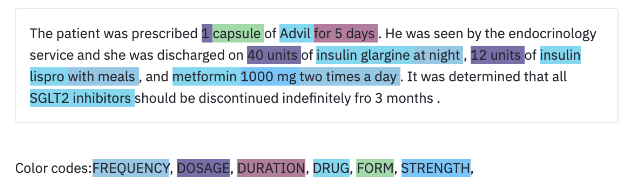

In [40]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

# greedy model
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    posology_ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
[OK!]
ner_posology_greedy download started this may take some time.
[OK!]


In [41]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [42]:
posology_result = posology_model.transform(mt_samples_df).cache()

In [43]:
posology_result.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|
|    2|Sample T

In [44]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy| id|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|  0|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|

In [45]:
posology_result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [46]:
posology_result.select('token.result','ner.result').show(5, truncate=80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                          result|                                                                          result|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, 

In [47]:
from pyspark.sql import functions as F

posology_result.select(F.explode(F.arrays_zip(posology_result.token.result, 
                                              posology_result.ner.result, 
                                              posology_result.ner.metadata)).alias("cols")) \
               .select(F.expr("cols['0']").alias("token"),
                       F.expr("cols['1']").alias("ner_label"),
                       F.expr("cols['2']['confidence']").alias("confidence"))\
               .filter("ner_label!='O'")\
               .show(20, truncate=100)


+--------------+-----------+----------+
|         token|  ner_label|confidence|
+--------------+-----------+----------+
|      Coumadin|     B-DRUG|    0.9989|
|             1| B-STRENGTH|    0.8618|
|            mg| I-STRENGTH|    0.5132|
|         daily|B-FREQUENCY|    0.9999|
|    Amiodarone|     B-DRUG|    0.9993|
|           100| B-STRENGTH|    0.8538|
|            mg| I-STRENGTH|    0.5216|
|           p.o|    B-ROUTE|    0.9992|
|         daily|B-FREQUENCY|    0.9928|
|      Coumadin|     B-DRUG|    0.9915|
|       Lovenox|     B-DRUG|    0.8314|
|            40| B-STRENGTH|    0.5199|
|            mg| I-STRENGTH|    0.5121|
|subcutaneously|    B-ROUTE|    0.9887|
|  chemotherapy|     B-DRUG|    0.9984|
|     cisplatin|     B-DRUG|    0.9257|
|            75| B-STRENGTH|    0.9574|
| mg/centimeter| I-STRENGTH|    0.5491|
|           109| B-STRENGTH|    0.5699|
|            mg| I-STRENGTH|    0.6355|
+--------------+-----------+----------+
only showing top 20 rows



In [48]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk.result, 
                                                   posology_result.ner_chunk.begin, 
                                                   posology_result.ner_chunk.end, 
                                                   posology_result.ner_chunk.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                             F.expr("cols['0']").alias("chunk"),
                             F.expr("cols['1']").alias("begin"),
                             F.expr("cols['2']").alias("end"),
                             F.expr("cols['3']['entity']").alias("ner_label"),
                             F.expr("cols['3']['confidence']").alias("confidence"))\
                    .filter("ner_label!='O'")\
                    .show(truncate=False)

+---+-----------+----------------+-----+----+---------+----------+
|id |sentence_id|chunk           |begin|end |ner_label|confidence|
+---+-----------+----------------+-----+----+---------+----------+
|0  |33         |Coumadin        |1609 |1616|DRUG     |0.9989    |
|0  |33         |1 mg            |1618 |1621|STRENGTH |0.6875    |
|0  |33         |daily           |1623 |1627|FREQUENCY|0.9999    |
|0  |34         |Amiodarone      |1696 |1705|DRUG     |0.9993    |
|0  |34         |100 mg          |1707 |1712|STRENGTH |0.68770003|
|0  |34         |p.o             |1714 |1716|ROUTE    |0.9992    |
|0  |34         |daily           |1719 |1723|FREQUENCY|0.9928    |
|0  |58         |Coumadin        |2770 |2777|DRUG     |0.9915    |
|0  |60         |Lovenox         |2880 |2886|DRUG     |0.8314    |
|0  |60         |40 mg           |2888 |2892|STRENGTH |0.51600003|
|0  |60         |subcutaneously  |2894 |2907|ROUTE    |0.9887    |
|0  |72         |chemotherapy    |4436 |4447|DRUG     |0.9984 

In [49]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk_greedy.result, 
                                                   posology_result.ner_chunk_greedy.begin, 
                                                   posology_result.ner_chunk_greedy.end, 
                                                   posology_result.ner_chunk_greedy.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                             F.expr("cols['0']").alias("chunk"),
                             F.expr("cols['1']").alias("begin"),
                             F.expr("cols['2']").alias("end"),
                             F.expr("cols['3']['entity']").alias("ner_label"),
                             F.expr("cols['3']['confidence']").alias("confidence"))\
                    .filter("ner_label!='O'")\
                    .show(truncate=False)

+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|id |sentence_id|chunk                                                         |begin|end |ner_label|confidence|
+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|0  |33         |Coumadin 1 mg                                                 |1609 |1621|DRUG     |0.6126    |
|0  |33         |daily                                                         |1623 |1627|FREQUENCY|0.9962    |
|0  |34         |Amiodarone 100 mg p.o                                         |1696 |1716|DRUG     |0.64115   |
|0  |34         |daily                                                         |1719 |1723|FREQUENCY|0.9035    |
|0  |58         |Coumadin                                                      |2770 |2777|DRUG     |0.99      |
|0  |72         |chemotherapy                                                  |4436 |4447|DRUG 

In [50]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'Xylocaine'

In [51]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'sentence': '11',
 'chunk': '0',
 'ner_source': 'ner_chunk',
 'entity': 'DRUG',
 'confidence': '0.9906'}

In [52]:
posology_light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

posology_light_result = posology_light_model.annotate(text)

list(zip(posology_light_result['token'], posology_light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [53]:
list(zip(posology_light_result['token'], posology_light_result['ner_greedy']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DRUG'),
 ('capsule', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('Advil', 'I-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'I-DRUG'),
 ('mg', 'I-DRUG'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 

In [54]:
cols = [
     'entities_ner_chunk',
     'entities_ner_chunk_class',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
]
posology_result_df = nlu.to_pretty_df(posology_light_model, text, positions=True, output_level='chunk')[cols]
posology_result_df.head(20)

,entities_ner_chunk,entities_ner_chunk_class,entities_ner_chunk_begin,entities_ner_chunk_end
0,1,DOSAGE,27,27
0,capsule,FORM,29,35
0,Advil,DRUG,40,44
0,for 5 days,DURATION,46,55
0,40 units,DOSAGE,126,133
0,insulin glargine,DRUG,138,153
0,at night,FREQUENCY,155,162
0,12 units,DOSAGE,166,173
0,insulin lispro,DRUG,178,191
0,with meals,FREQUENCY,193,202


In [55]:
cols = [
     'entities_ner_chunk_greedy',
     'entities_ner_chunk_greedy_class',
     'entities_ner_chunk_greedy_begin',
     'entities_ner_chunk_greedy_end',
]
posology_result_greedy_df = nlu.to_pretty_df(posology_light_model, text, positions=True, output_level='chunk')[cols]
posology_result_greedy_df.head(10)

,entities_ner_chunk_greedy,entities_ner_chunk_greedy_class,entities_ner_chunk_greedy_begin,entities_ner_chunk_greedy_end
0,1 capsule of Advil,DRUG,27,44
0,for 5 days,DURATION,46,55
0,40 units of insulin glargine,DRUG,126,153
0,at night,FREQUENCY,155,162
0,12 units of insulin lispro,DRUG,166,191
0,with meals,FREQUENCY,193,202
0,metformin 1000 mg,DRUG,210,226
0,two times a day,FREQUENCY,228,242
0,SGLT2 inhibitors,DRUG,273,288
0,for 3 months,DURATION,326,337


### Comparison of `ner_posology` and `ner_posology_greedy` results

In [56]:
posology_light_result= posology_light_model.fullAnnotate(text)

from google.colab import widgets

t = widgets.TabBar(["ner_posology", "ner_posology_greedy", "viz_posology", "viz_posology_greedy"])

with t.output_to(0):
    display(posology_result_df.head(10))

with t.output_to(1):
    display(posology_result_greedy_df.head(10))

with t.output_to(2):
    visualiser.display(posology_light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(posology_light_result[0], label_col='ner_chunk_greedy', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,entities_ner_chunk,entities_ner_chunk_class,entities_ner_chunk_begin,entities_ner_chunk_end
0,1,DOSAGE,27,27
0,capsule,FORM,29,35
0,Advil,DRUG,40,44
0,for 5 days,DURATION,46,55
0,40 units,DOSAGE,126,133
0,insulin glargine,DRUG,138,153
0,at night,FREQUENCY,155,162
0,12 units,DOSAGE,166,173
0,insulin lispro,DRUG,178,191
0,with meals,FREQUENCY,193,202


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,entities_ner_chunk_greedy,entities_ner_chunk_greedy_class,entities_ner_chunk_greedy_begin,entities_ner_chunk_greedy_end
0,1 capsule of Advil,DRUG,27,44
0,for 5 days,DURATION,46,55
0,40 units of insulin glargine,DRUG,126,153
0,at night,FREQUENCY,155,162
0,12 units of insulin lispro,DRUG,166,191
0,with meals,FREQUENCY,193,202
0,metformin 1000 mg,DRUG,210,226
0,two times a day,FREQUENCY,228,242
0,SGLT2 inhibitors,DRUG,273,288
0,for 3 months,DURATION,326,337


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Writing a generic NER function

**Generic NER Function with LightPipeline**

In [57]:
def get_light_model(embeddings, model_name = 'ner_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverterInternal() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  nlpPipeline = Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      loaded_ner_model,
      ner_converter])

  model = nlpPipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

  return LightPipeline(model)

In [58]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

light_model = get_light_model(embeddings, model_name)

text = "I had a headache yesterday and took an Advil."

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]


In [59]:
cols = [
     'entities_ner_chunk_origin_sentence',
     'entities_ner_chunk_begin',
     'entities_ner_chunk_end',
     'entities_ner_chunk',
     'entities_ner_chunk_class',
]

nlu.to_pretty_df(light_model, text, positions=True, output_level='chunk')[cols]

,entities_ner_chunk_origin_sentence,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk,entities_ner_chunk_class
0,0,6,15,a headache,PROBLEM
0,0,36,43,an Advil,TREATMENT


In [60]:
text ='''The patient was prescribed 1 capsule of Parol with meals . 
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'''

embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

light_model = get_light_model(embeddings, model_name)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology download started this may take some time.
[OK!]


In [61]:
nlu.to_pretty_df(light_model, text,positions=True, output_level='chunk')[cols]

,entities_ner_chunk_origin_sentence,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk,entities_ner_chunk_class
0,0,27,27,1,DOSAGE
0,0,29,35,capsule,FORM
0,0,40,44,Parol,DRUG
0,0,46,55,with meals,FREQUENCY
0,1,127,134,40 units,DOSAGE
0,1,139,154,insulin glargine,DRUG
0,1,156,163,at night,FREQUENCY
0,1,167,174,12 units,DOSAGE
0,1,179,192,insulin lispro,DRUG
0,1,194,203,with meals,FREQUENCY


## PHI NER

**Entities**
- AGE
- CONTACT
- DATE
- ID
- LOCATION
- NAME
- PROFESSION

In [62]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_subentity_augmented'

# deidentify_dl
# ner_deid_large
# ner_deid_generic_augmented
# ner_deid_subentity_augmented
# ner_deid_subentity_augmented_i2b2

text = """Miriam BRAY is a 41-year-old female from Vietnam and she was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold.
She was instructed to followup with Dr. XYZ in the office to check her INR On August 24, 2007 ."""

light_model = get_light_model(embeddings, model_name)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
[OK!]


In [63]:
nlu.to_pretty_df(light_model,text,positions=True,output_level='chunk')[cols]

,entities_ner_chunk_origin_sentence,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk,entities_ner_chunk_class
0,0,0,10,Miriam BRAY,PATIENT
0,0,17,27,41-year-old,AGE
0,0,41,47,Vietnam,COUNTRY
0,0,126,131,Monday,DATE
0,0,140,140,X,DOCTOR
0,1,216,218,XYZ,DOCTOR
0,1,254,268,"August 24, 2007",DATE


## Oncology NER

There are several Oncology NER models in Spark NLP. We will show an example of `new_oncology_wip` model here.

**Entities**

| | | | |
|-|-|-|-|
| Invasion | Dosage | Hormonal_Therapy | Site_Lung |
| Biomarker_Result | Response_To_Treatment | Oncogene | Relative_Date |
| Site_Bone | Histological_Type | Radiation_Dose | Age |
| Duration | Grade | Tumor_Size | Line_Of_Therapy |
| Site_Breast | Cancer_Surgery | Smoking_Status | Imaging_Test |
| Adenopathy | Targeted_Therapy | Radiotherapy | Metastasis |
| Date | Cycle_Number | Pathology_Result | Cancer_Score |
| Cancer_Dx | Death_Entity | Site_Liver | Site_Brain |
| Pathology_Test | Chemotherapy | Biomarker | Frequency |
| Site_Lymph_Node | Performance_Status | Unspecific_Therapy | Cycle_Count |
| Race_Ethnicity | Gender | Staging | Immunotherapy |
| Site_Other_Body_Part | Tumor_Finding | Route | Cycle_Day |
| Direction| | | |

You can check [Oncology Model Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/27.Oncology_Model.ipynb) for more examples.


In [64]:
mt_samples_df.limit(1).collect()[0]["text"]

'Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to a

In [65]:
embeddings = 'embeddings_clinical'

model_name = 'ner_oncology'

text =  mt_samples_df.limit(1).collect()[0]["text"]

light_model = get_light_model(embeddings, model_name)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_oncology download started this may take some time.
[OK!]


In [66]:
nlu.to_pretty_df(light_model, text, positions=True, output_level='chunk')[cols].head(20).reset_index(drop=True)

,entities_ner_chunk_origin_sentence,entities_ner_chunk_begin,entities_ner_chunk_end,entities_ner_chunk,entities_ner_chunk_class
0,0,118,129,Mesothelioma,Cancer_Dx
1,4,471,485,"August 24, 2007",Date
2,4,488,500,decortication,Cancer_Surgery
3,4,509,512,lung,Site_Lung
4,4,519,525,pleural,Site_Lung
5,4,527,532,biopsy,Pathology_Test
6,4,538,561,transpleural fluoroscopy,Imaging_Test
7,5,570,584,"August 20, 2007",Date
8,6,608,622,"August 31, 2007",Date
9,7,687,697,41-year-old,Gender


## NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract drug and frequency together as a single chunk even if there are some unwanted tokens between them. 

In [67]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]


In [68]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [69]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 'O'),
 ('det

In [70]:
light_result["ner_chunk"]

['insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day']

## Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [71]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['Advil','metformin', 'insulin lispro'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]


In [72]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['document', 'ner_chunk', 'chunk_filtered', 'token', 'ner', 'embeddings', 'sentence'])

In [73]:
light_result['ner_chunk'] 

['1',
 'capsule',
 'Advil',
 'for 5 days',
 '40 units',
 'insulin glargine',
 'at night',
 '12 units',
 'insulin lispro',
 'with meals',
 'metformin',
 '1000 mg',
 'two times a day',
 'SGLT2 inhibitors']

In [74]:
light_result['chunk_filtered']

['Advil', 'insulin lispro', 'metformin']

In [75]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence","token","embeddings")\
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")
    
chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['severe fever','sore throat'])

#   .setCriteria("regex")\

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
[OK!]


In [76]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [77]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

+-------------------------------------------------------------------+---------------------------+
|result                                                             |result                     |
+-------------------------------------------------------------------+---------------------------+
|[severe fever, severe cough, sore throat, stomach pain, a headache]|[severe fever, sore throat]|
+-------------------------------------------------------------------+---------------------------+



## Changing entity labels with `NerConverterInternal()`

There are two parameters in `NerConverterInternal()` annotator for replacing the labels. 

+ `.setReplaceLabels`: You can just create a dictionary with the labels and their new values in this parameter.

```python
jsl_ner_converter_internal = medical.NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Frequency": "Drug_Frequency",
                       "Dosage": "Drug_Dosage",
                       "Strength": "Drug_Strength"})
```

+ `.setReplaceDictResource`: You can feed a file that contains the labels and their new values in a dictionary format. 

```python
replace_dict = """Drug_BrandName,Drug
Frequency,Drug_Frequency
Dosage,Drug_Dosage
Strength,Drug_Strength
"""
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

...
jsl_ner_converter_internal = medical.NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})
...
```



You can check [NerConverterInternal Annotator Page](https://nlp.johnsnowlabs.com/docs/en/licensed_annotators#nerconverterinternal) for more details.

In [78]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") 

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Frequency": "Drug_Frequency",
                       "Dosage": "Drug_Dosage",
                       "Strength": "Drug_Strength"})
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]


In [79]:
text ='The patient was prescribed 1 capsule of Parol with meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

#light_model = LightPipeline(ner_converter_model)

cols = [
     'entities_jsl_ner_chunk_origin_sentence',
     'entities_jsl_ner_chunk_begin',
     'entities_jsl_ner_chunk_end',
     'entities_jsl_ner_chunk',
     'entities_jsl_ner_chunk_class',
     'entities_replaced_ner_chunk_class'
]
nlu.to_pretty_df(ner_converter_model,text,positions=True,output_level='chunk')[cols].head(20)

,entities_jsl_ner_chunk_origin_sentence,entities_jsl_ner_chunk_begin,entities_jsl_ner_chunk_end,entities_jsl_ner_chunk,entities_jsl_ner_chunk_class,entities_replaced_ner_chunk_class
0,0,27,35,1 capsule,Dosage,Drug_Dosage
0,0,40,44,Parol,Drug_BrandName,Drug
0,1,58,59,He,Gender,Gender
0,1,77,97,endocrinology service,Clinical_Dept,Clinical_Dept
0,1,103,105,she,Gender,Gender
0,1,111,120,discharged,Admission_Discharge,Admission_Discharge
0,1,125,132,40 units,Dosage,Drug_Dosage
0,1,137,152,insulin glargine,Drug_Ingredient,Drug_Ingredient
0,1,154,161,at night,Frequency,Drug_Frequency
0,1,165,172,12 units,Dosage,Drug_Dosage


### Adding `setIgnoreStopWords` parameter to control chunk generation.
By providing `setIgnoreStopWords`, we can ignore certain words or characters while creating a chunk. <br/>

It should be a list of tokens/words or characters, and when two entities of the same type are separated by those words, these entities can be combined to produce a single, larger chunk.






Firstly let's create `NerConverterInternal()` without this parameter

In [80]:
jsl_ner= MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models")\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setOutputCol("ner_deid")\
      .setLabelCasing('upper')

jsl_ner_converter_internal= NerConverterInternal()\
        .setInputCols(["sentence", "token", "ner_deid"])\
        .setOutputCol("chunk_deid")\
        .setGreedyMode(True)\
        .setWhiteList(['LOCATION'])
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

ner_deid_generic_augmented download started this may take some time.
[OK!]


In [81]:
from sparknlp_display import NerVisualizer

text = """
The address of the manufacturer:
R K Industry House, Walbhat Rd
Mumbai, Maharashtra, India
"""

lmodel= LightPipeline(ner_converter_model)
res = lmodel.fullAnnotate(text)[0]

NerVisualizer().display(res, 'chunk_deid')

Now, let's define some characters and words with the `setIgnoreStopWords()` parameter and see the difference between the chunks. 

In [82]:
jsl_ner_converter_internal= NerConverterInternal()\
        .setInputCols(["sentence", "token", "ner_deid"])\
        .setOutputCol("chunk_deid")\
        .setGreedyMode(True)\
        .setWhiteList(['LOCATION'])\
        .setIgnoreStopWords(['\n', ',', "and", 'or', '.'])
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

In [83]:
lmodel= LightPipeline(ner_converter_model)
res = lmodel.fullAnnotate(text)[0]

NerVisualizer().display(res, 'chunk_deid')

## Downloading Pretrained Models

- When we use `.pretrained` method, model is downloaded to  a folder named `cache_pretrained` automatically and it is loaded from this folder if you run it again.

- In order to download the models manually to any folder, you can use `ResourceDownloader.downloadModelDirectly` from `sparknlp.pretrained` or AWS CLI (steps below). In this case you should use `.load()` method.

  - Install AWS CLI to your local computer following the steps [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html) for Linux and [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html) for MacOS.

  - Then configure your AWS credentials.

  - Go to models hub and look for the model you need.

  - Select the model you found and you will see the model card that shows all the details about that model.

  - Hover the Download button on that page and you will see the download link from the S3 bucket. 


In [84]:
!cd /root && ls

cache_pretrained


In [85]:
from sparknlp.pretrained import ResourceDownloader

#The first argument is the path to the zip file and the second one is the folder.
ResourceDownloader.downloadModelDirectly("clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip", "cache_pretrained")  

#or you can use the classic AWS CLI 
# !aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .

## Training a Clinical NER (NCBI Disease Dataset)

`CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")`  this methos can allow if you have doc_id information in the conll file, you can add this information to the dataframe as a column. 

```
conll="""-DOCSTART- -X- -1- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O

-DOCSTART- -X- 2 O

Rare NNP B-NP O
Hendrix NNP I-NP B-PER

-DOCSTART- -X- -3-1- O

China NNP B-NP B-LOC
says VBZ B-VP O

-DOCSTART-

China NNP B-NP B-LOC
says VBZ B-VP O
"""
```
```
with open('conll_file.txt', 'w') as f:
    f.write(conll)

data = CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")

data.show()
```



```
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|               token|                 pos|               label|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     1|EU rejects German...|[{document, 0, 28...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     2|Rare Hendrix song...|[{document, 0, 97...|[{document, 0, 50...|[{token, 0, 3, Ra...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|
|   3-1|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
|     X|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
```

In [86]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [87]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [88]:
conll_data.count()

3266

In [89]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,
                                         conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [90]:
conll_data.select("label.result").distinct().count()

1537

In [ ]:
'''
As you can see, there are too many `O` labels in the dataset. 
To make it more balanced, we can drop the sentences have only O labels.
(`c>1` means we drop all the sentences that have no valuable labels other than `O`)
'''

'''
conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)
'''

In [92]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [93]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

test_data.write.parquet('NER_NCBIconlltest.parquet')

### NERDL Graph


We will use `TFGraphBuilder` annotator which can be used to create graphs in the model training pipeline. `TFGraphBuilder` inspects the data and creates the proper graph if a suitable version of TensorFlow is available. The graph is stored in the defined folder and loaded by the `MedicalNerApproach` annotator.

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-addons

In [95]:
from sparknlp_jsl.annotator import TFGraphBuilder

graph_folder_path = "medical_ner_graphs"

ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder_path)\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(20)\
    .setIsLicensed(True) # False -> if you want to use TFGraphBuilder with NerDLApproach

In [ ]:
# TensorFlow graph file (`.pb` extension) can be produced for NER training externally. 
# If this method is used, graph folder should be added to MedicalNerApproach training 
# model as `.setGraphFolder(graph_folder_path)` .

'''
from sparknlp_jsl.training import tf_graph

tf_graph.print_model_params("ner_dl")

graph_folder_path = "medical_ner_graphs"
tf_graph.build("ner_dl", 
               build_params={"embeddings_dim": 200, 
                             "nchars": 85, 
                             "ntags": 3, 
                             "is_medical": 1}, 
               model_location=graph_folder_path, 
               model_filename="auto")
'''

In [ ]:
# for open source users

'''
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

!pip -q install tensorflow==1.15.0

import create_graph

ntags = 3 # number of labels
embeddings_dim = 200
nchars =83

create_graph.create_graph(ntags, embeddings_dim, nchars)
'''

We will use `setEarlyStoppingCriterion` and `setEarlyStoppingPatience` parameters to stop training if it doesn't improve any more. Also, these parameters will provide us to save time and resources.

- `setEarlyStoppingCriterion(float)`: This parameter is used to set the minimal improvement of the test metric to terminate training. The metric monitored is the same which is used to save the best best model (macro F1 if using test or validation set, loss otherwise). If it is F1, then training is stopped if `F1_current - F1_previous < earlyStoppingCriterion`. If monitoring loss, then training is stopped if `loss_previous - loss_current < earlyStoppingCriterion`. If earlyStoppingCriterion is `0`, then no early stopping is applied. Default is `0`.

- `setEarlyStoppingPatience(int)`: This is the number of epoch without improvement which will be tolerated. Default is `0`, which means that early stopping will occur at the first time when performance in the current epoch is no better than in the previous epoch (taking earlyStoppingCriterion into account).

In [98]:
nerTagger = MedicalNerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(30)\
    .setBatchSize(64)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('ner_logs')\
    .setTestDataset("NER_NCBIconlltest.parquet")\
    .setUseBestModel(True)\
    .setEarlyStoppingCriterion(0.04)\
    .setEarlyStoppingPatience(3)\
    .setGraphFolder(graph_folder_path)
   # .setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch       

ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          ner_graph_builder,
          nerTagger
 ])

You can visit [1.4.Resume_MedicalNer_Model_Training.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.4.Resume_MedicalNer_Model_Training.ipynb) notebook for fine-tuning pretrained NER models and more details of `MedicalNerApproach()` parameters.

In [99]:
%%time
ner_model = ner_pipeline.fit(conll_data)

TF Graph Builder configuration:
Model name: ner_dl
Graph folder: medical_ner_graphs
Graph file name: auto
Build params: {'ntags': 3, 'embeddings_dim': 200, 'nchars': 85, 'is_medical': True, 'lstm_size': 20}


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ner_dl graph exported to medical_ner_graphs/blstm_3_200_20_85.pb
CPU times: user 18.7 s, sys: 1.11 s, total: 19.8 s
Wall time: 3min 58s


If you get an error for incompatible TF graph, use [4.1 NerDL-Graph](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.1_NerDL_Graph.ipynb) notebook in public folder to create a graph

Licensed users can also use [17.Graph_builder_for_DL_models.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/17.Graph_builder_for_DL_models.ipynb) to create TF graphs easily.


`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [100]:
ner_model.stages[2].getTrainingClassDistribution()

{'O': 58934, 'B-Disease': 2461, 'I-Disease': 2826}

Let's check the results saved in the log file.

In [101]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: /content/medical_ner_graphs/blstm_3_200_20_85.pb
Training started - total epochs: 30 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 84 - training examples: 2587


Epoch 1/30 started, lr: 0.001, dataset size: 2587


Epoch 1/30 - 15.30s - loss: 298.07056 - avg training loss: 7.096918 - batches: 42
Quality on validation dataset (20.0%), validation examples = 517
time to finish evaluation: 1.89s
Total validation loss: 63.1113	Avg validation loss: 4.5079
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 62	 50	 659	 0.5535714	 0.08599168	 0.14885955
B-Disease	 5	 1	 627	 0.8333333	 0.0079113925	 0.015673982
tp: 67 fp: 51 fn: 1286 labels: 2
Macro-average	 prec: 0.69345236, rec: 0.046951536, f1: 0.08794836
Micro-average	 prec: 0.5677966, rec: 0.049519587, f1: 0.091094494
Quality on test dataset: 
time to finish evaluation: 1.57s
Total test loss: 71.8588	Avg test loss: 5.1328
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 92	 87	 697	 0.5139665	 0.11660329	 0.19008264
B-D

As you see above, our **earlyStopping** feature worked, trainining was terminated before 30th epoch.

### Evaluate your model

In [102]:
pred_df = ner_model.stages[2].transform(test_data)

In [103]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [104]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+------+
| entity|   tp|   fp|   fn|total|precision|recall|    f1|
+-------+-----+-----+-----+-----+---------+------+------+
|Disease|511.0|160.0|193.0|704.0|   0.7615|0.7259|0.7433|
+-------+-----+-----+-----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.7432727272727273|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.7432727272727273|
+------------------+

None


In [105]:
evaler = NerDLMetrics(mode="partial_chunk_per_token")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1201.0|127.0|296.0|1497.0|   0.9044|0.8023|0.8503|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8502654867256637|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8502654867256637|
+------------------+

None


`ner_utils`: This new module is used after NER training to calculate mertic chunkbase and plot training logs.

`evaluate`: if verbose, returns overall performance, as well as performance per chunk type; otherwise, simply returns overall precision, recall, f1 scores

`loss_plot`: Plots the figure of loss vs epochs

`get_charts` : Plots the figures of metrics ( precision, recall, f1) vs epochs

```
from sparknlp_jsl.utils.ner_utils import get_charts, loss_plot, evaluate

metrics = evaluate( preds_df['prediction'].values, preds_df['ground_truth'].values)

loss_plot(f"./ner_logs/{log_file}")

get_charts('./ner_logs/'+log_files[0])
```

In [106]:
ner_model.stages[2].write().overwrite().save('models/custom_NER_30epoch')

In [107]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("models/custom_NER_30epoch")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverterInternal()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages=[
    document,
    sentence,
    token,
    clinical_embeddings,
    loaded_ner_model,
    converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [108]:
text = "She has a metastatic breast cancer"

result = light_model.fullAnnotate(text)[0]

[(i.result, i.metadata['entity']) for i in result['ner_span']]

[('metastatic breast cancer', 'Disease')]

## BertForTokenClassification NER models

In [109]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols("token", "sentence")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pipeline =  Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    tokenClassifier,
    ner_converter
    ])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . 
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . 
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . 
Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . 
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . 
However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . 
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . 
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . 
Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge ."""

res = model.transform(spark.createDataFrame([[text]]).toDF("text"))

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
[OK!]


In [110]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result, 
                                  res.ner_chunk.begin, 
                                  res.ner_chunk.end, 
                                  res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['3']['sentence']").alias("sentence_id"),
           F.expr("cols['0']").alias("chunk"),
           F.expr("cols['2']").alias("end"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)

+-----------+-----------------------------+---+---------+
|sentence_id|chunk                        |end|ner_label|
+-----------+-----------------------------+---+---------+
|0          |gestational diabetes mellitus|67 |PROBLEM  |
|0          |type two diabetes mellitus   |153|PROBLEM  |
|0          |T2DM                         |160|PROBLEM  |
|0          |HTG-induced pancreatitis     |209|PROBLEM  |
|0          |an acute hepatitis           |280|PROBLEM  |
|0          |obesity                      |294|PROBLEM  |
|0          |a body mass index            |317|TEST     |
|0          |BMI                          |323|TEST     |
|0          |polyuria                     |387|PROBLEM  |
|0          |polydipsia                   |400|PROBLEM  |
|0          |poor appetite                |416|PROBLEM  |
|0          |vomiting                     |431|PROBLEM  |
|1          |amoxicillin                  |522|TREATMENT|
|1          |a respiratory tract infection|556|PROBLEM  |
|2          |m

In [111]:
light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_bert_result.html")

**Training Clinical BertForTokenClassification Model**

For training own BertForTokenClassification NER model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.5.BertForTokenClassification_NER_SparkNLP_with_Transformers.ipynb)

## Pretrained NER Profiling Pipelines

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once. In Spark NLP we have two different NER profiling pipelines;

- `ner_profiling_clinical` : Returns results for clinical NER models trained with `embeddings_clinical`.
- `ner_profiling_biobert` : Returns results for clinical NER models trained with `biobert_pubmed_base_cased`.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).





<center><b>NER Profiling Clinical Model List</b>

|| | | |
|--------------|-----------------|-----------------|-----------------|
| jsl_ner_wip_clinical | jsl_ner_wip_greedy_clinical | jsl_ner_wip_modifier_clinical | jsl_rd_ner_wip_greedy_clinical |
| ner_abbreviation_clinical | ner_ade_binary | ner_ade_clinical | ner_anatomy |
| ner_anatomy_coarse | ner_bacterial_species | ner_biomarker | ner_biomedical_bc2gm |
| ner_bionlp | ner_cancer_genetics | ner_cellular | ner_chemd_clinical |
| ner_chemicals | ner_chemprot_clinical | ner_chexpert | ner_clinical |
| ner_clinical_large | ner_clinical_trials_abstracts | ner_covid_trials | ner_deid_augmented |
| ner_deid_enriched | ner_deid_generic_augmented | ner_deid_large | ner_deid_sd |
| ner_deid_sd_large | ner_deid_subentity_augmented | ner_deid_subentity_augmented_i2b2 | ner_deid_synthetic |
| ner_deidentify_dl | ner_diseases | ner_diseases_large | ner_drugprot_clinical |
| ner_drugs | ner_drugs_greedy | ner_drugs_large | ner_events_admission_clinical |
| ner_events_clinical | ner_genetic_variants | ner_human_phenotype_gene_clinical | ner_human_phenotype_go_clinical |
| ner_jsl | ner_jsl_enriched | ner_jsl_greedy | ner_jsl_slim |
| ner_living_species | ner_measurements_clinical | ner_medmentions_coarse | ner_nature_nero_clinical |
| ner_nihss | ner_pathogen | ner_posology | ner_posology_experimental |
| ner_posology_greedy | ner_posology_large | ner_posology_small | ner_radiology |
| ner_radiology_wip_clinical | ner_risk_factors | ner_supplement_clinical | nerdl_tumour_demo |

<b>NER Profiling BioBert Model List</b>

| | |
|-|-|
| ner_cellular_biobert           | ner_clinical_biobert             |
| ner_diseases_biobert           | ner_anatomy_coarse_biobert       |
| ner_events_biobert             | ner_human_phenotype_gene_biobert |
| ner_bionlp_biobert             | ner_posology_large_biobert       |
| ner_jsl_greedy_biobert         | jsl_rd_ner_wip_greedy_biobert    |
| ner_jsl_biobert                | ner_posology_biobert             |
| ner_anatomy_biobert            | jsl_ner_wip_greedy_biobert       |
| ner_jsl_enriched_biobert       | ner_chemprot_biobert             |
| ner_human_phenotype_go_biobert | ner_ade_biobert                  |
| ner_deid_biobert               | ner_risk_factors_biobert         |
| ner_deid_enriched_biobert      | ner_living_species_biobert                                |


</center>

In [112]:
from sparknlp.pretrained import PretrainedPipeline

clinical_profiling_pipeline = PretrainedPipeline("ner_profiling_clinical", "en", "clinical/models")

ner_profiling_clinical download started this may take some time.
Approx size to download 2.5 GB
[OK!]


In [113]:
text = '''A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .'''

In [114]:
clinical_result = clinical_profiling_pipeline.fullAnnotate(text)[0]
clinical_result.keys()

dict_keys(['ner_ade_clinical_chunks', 'ner_deid_augmented', 'ner_deid_subentity_augmented_i2b2', 'ner_posology_greedy_chunks', 'ner_radiology_wip_clinical', 'ner_deidentify_dl', 'ner_jsl_slim', 'ner_risk_factors_chunks', 'jsl_ner_wip_clinical_chunks', 'ner_deid_synthetic', 'ner_drugs_greedy', 'ner_abbreviation_clinical_chunks', 'ner_covid_trials_chunks', 'ner_human_phenotype_gene_clinical_chunks', 'ner_events_admission_clinical', 'jsl_ner_wip_greedy_clinical_chunks', 'ner_posology_greedy', 'ner_cellular_chunks', 'ner_cancer_genetics_chunks', 'ner_biomedical_bc2gm_chunks', 'ner_jsl_greedy', 'jsl_ner_wip_modifier_clinical_chunks', 'ner_drugs_greedy_chunks', 'ner_deid_sd_large_chunks', 'ner_diseases_chunks', 'ner_diseases_large', 'ner_chemprot_clinical', 'ner_posology_large', 'nerdl_tumour_demo_chunks', 'ner_deid_subentity_augmented_chunks', 'ner_jsl_enriched_chunks', 'ner_genetic_variants_chunks', 'ner_chexpert', 'ner_bionlp_chunks', 'ner_measurements_clinical_chunks', 'ner_diseases_larg

In [115]:
def get_token_results(light_result):

  tokens = [j.result for j in light_result["token"]]
  sentences = [j.metadata["sentence"] for j in light_result["token"]]
  begins = [j.begin for j in light_result["token"]]
  ends = [j.end for j in light_result["token"]]
  model_list = [ a for a in light_result.keys() if (a not in ["sentence", "token"] and "_chunks" not in a)]

  df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

  for model_name in model_list:
    
    temp_df = pd.DataFrame(light_result[model_name])
    temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
    temp_df = temp_df[["jsl_label"]]

    # temp_df = get_ner_result(model_name)
    temp_df.columns = [model_name]
    df = pd.concat([df, temp_df], axis=1)
    
  return df

In [116]:
get_token_results(clinical_result)

,sentence,begin,end,token,ner_deid_augmented,ner_deid_subentity_augmented_i2b2,ner_radiology_wip_clinical,ner_deidentify_dl,ner_jsl_slim,ner_deid_synthetic,...,ner_posology_experimental,jsl_ner_wip_clinical,ner_biomedical_bc2gm,ner_jsl,ner_events_clinical,ner_supplement_clinical,ner_genetic_variants,ner_radiology,ner_posology,ner_covid_trials
0,0,0,0,A,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
1,0,2,12,28-year-old,O,O,O,O,B-Age,O,...,O,B-Age,O,B-Age,O,O,O,O,O,B-Age
2,0,14,19,female,O,O,O,O,B-Demographics,O,...,O,B-Gender,O,B-Gender,O,O,O,O,O,B-Gender
3,0,21,24,with,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
4,0,26,26,a,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,409,416,appetite,O,O,I-Symptom,O,I-Symptom,O,...,O,I-Symptom,O,I-Symptom,I-PROBLEM,O,O,I-Symptom,O,O
69,0,418,418,",",O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
70,0,420,422,and,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
71,0,424,431,vomiting,O,O,B-Symptom,O,B-Symptom,O,...,O,B-Symptom,O,B-Symptom,B-PROBLEM,B-CONDITION,O,B-Symptom,O,O


**Lets plot the labelled entity counts by NER models.**

In [117]:
import plotly.graph_objects as go

result_df = get_token_results(clinical_result)

label_result_df = result_df[result_df.columns[4:]].copy()
label_count_list = [label_result_df[label_result_df[i] != "O"].shape[0] for i in label_result_df.columns]

fig = go.Figure(go.Bar(x=label_count_list, y=label_result_df.columns, orientation='h'))

fig.update_layout(
    autosize = False,
    width = 1500,
    height = 1500,
    margin = dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor = "LightSteelBlue",
    title={'text': "Counts of Labelled Entities", 'y':0.98, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    titlefont=dict(size=30),
    yaxis=dict(title_text="Clinical NER Models", titlefont=dict(size=30)),
)

fig.show()

## NER Model Finder Pretrained Pipeline
`ner_model_finder`  pretrained pipeline trained with bert embeddings that can be used to find the most appropriate NER model given the entity name.

In [118]:
from sparknlp.pretrained import PretrainedPipeline
finder_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

ner_model_finder download started this may take some time.
Approx size to download 148.7 MB
[OK!]


In [119]:
result = finder_pipeline.fullAnnotate("oncology")[0]
result.keys()

dict_keys(['model_names'])

From the metadata in the `model_names` column, we'll get to the top models to the given 'oncology' entity and oncology related categories.

In [120]:
df= pd.DataFrame(zip(result["model_names"][0].metadata["all_k_resolutions"].split(":::"), 
                     result["model_names"][0].metadata["all_k_results"].split(":::")), 
                 columns=["category", "top_models"])

df.head()

,category,top_models
0,oncology therapy,"['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim']"
1,clinical department,"['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_events_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim', 'ner_events_healthcare', 'ner_events_adm..."
2,biomedical unit,['ner_clinical_trials_abstracts']
3,cancer genetics,['ner_cancer_genetics']
4,anatomy,"['ner_bionlp', 'ner_medmentions_coarse', 'ner_chexpert', 'ner_anatomy_coarse', 'ner_anatomy', 'ner_nature_nero_clinical']"
